VALLOTA and BUNAG Exercise this is for the IRIS Dataset

In [1]:
# Library imports
import numpy as np

Create classes for modularity

In [2]:
# Hidden Layers
# Dense
class Layer_Dense:
    # Layer initialization
    # randomly initialize weights and set biases to zero
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))


    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs, weight and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass/Backpropagation
    def backward(self, dvalues):
        # Gradients on parameters:
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


In [3]:
# Activation Functions
# Included here are the functions for both the forward and backward pass

# Linear
class ActivationLinear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

# Sigmoid
class ActivationSigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (self.output * (1 - self.output))

# TanH
class ActivationTanH:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.tanh(inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output ** 2)

# ReLU
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Make a copy of the original values first
        self.dinputs = dvalues.copy()
    
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

# Softmax
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember the inputs values
        self.inputs = inputs

        # Get the unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate the sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [4]:
# Loss functions

class Loss:
    # Calculate the data and regularization losses
    # Given the model output and grou truth/target values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate the mean loss
        data_loss = np.mean(sample_losses)
        # Return the mean loss
        return data_loss

# MSE
class Loss_MSE:
    def forward(self, y_pred, y_true):
        # Calculate Mean Squared Error
        return np.mean((y_true - y_pred) ** 2, axis=-1)

    def backward(self, y_pred, y_true):
        # Gradient of MSE loss
        samples = y_true.shape[0]
        outputs = y_true.shape[1]
        self.dinputs = -2 * (y_true - y_pred) / outputs
        # Normalize gradients over samples
        self.dinputs = self.dinputs / samples

# Binary Cross-Entropy
class Loss_BinaryCrossEntropy:
    def forward(self, y_pred, y_true):
        # Clip predictions
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate Binary Cross Entropy
        return -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))

    def backward(self, y_pred, y_true):
        # Gradient of BCE loss
        samples = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        self.dinputs = - (y_true / y_pred_clipped - (1 - y_true) / (1 - y_pred_clipped))
        # Normalize gradients over samples
        self.dinputs = self.dinputs / samples

# Categorical Cross-Entropy
class Loss_CategoricalCrossEntropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = y_pred.shape[0]

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values
        # Only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # Use the first sample to count them
        labels = len(dvalues[0])

        # Check if labels are sparse, turn them into one-hot vector values
        # the eye function creates a 2D array with ones on the diagonal and zeros elsewhere
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate the gradient
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples


<!-- Star -->

In [5]:
# Enhanced Optimizer with multiple optimization techniques
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0., momentum=0., use_adagrad=False):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        self.use_adagrad = use_adagrad

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If we use momentum
        if self.momentum:
            # If layer does not contain momentum arrays, create them filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            # Build weight updates with momentum - take previous updates multiplied by retain factor
            # and update with current gradients
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            # Build bias updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        # If we use AdaGrad
        elif self.use_adagrad:
            # If layer does not contain cache arrays, create them filled with zeros
            if not hasattr(layer, 'weight_cache'):
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_cache = np.zeros_like(layer.biases)
            
            # Update cache with squared current gradients
            layer.weight_cache += layer.dweights**2
            layer.bias_cache += layer.dbiases**2
            
            # Vanilla SGD parameter update + normalization with square rooted cache
            weight_updates = -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + 1e-7)
            bias_updates = -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + 1e-7)
            
        # Vanilla SGD updates (as before)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases using either vanilla or momentum/AdaGrad updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

Use most of the classes to create a functioning neural network, capable of performing a forward and backward pass

We can use a sample dataset from the Spiral module.  

We can also use the IRIS dataset.

In [6]:
# Iris Dataset - Using this instead of Spiral Data
from sklearn.datasets import load_iris

# Create the dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Target labels

print("Dataset shape:", X.shape)
print("Target shape:", y.shape)
print("First 5 samples:")
print(X[:5])
print("First 5 targets:")
print(y[:5])

Dataset shape: (150, 4)
Target shape: (150,)
First 5 samples:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
First 5 targets:
[0 0 0 0 0]


In [7]:
# Iris Dataset
# From the scikit-learn library
# from sklearn.datasets import load_iris
# iris = load_iris()
# X = iris.data # Features
# y = iris.target # Target labels

# print(X[:5])
# print(X.shape)
# print(y[:5])
# print(y.shape)

In [8]:
# Neural Network initialization
# Create a Dense Layer with 4 input features (iris dataset) and 3 output values
dense1 = Layer_Dense(4, 3)  # Changed from 2 to 4 inputs

# Create a ReLU activation for the first Dense layer
activation1 = Activation_ReLU()

# Create a 2nd dense layer with 3 input and 3 output values
dense2 = Layer_Dense(3, 3)

# Create a Softmax activation for the 2nd Dense layer
activation2 = Activation_Softmax()

# Create a loss function
loss_function = Loss_CategoricalCrossEntropy()

# Create different optimizers for comparison
optimizer_vanilla = Optimizer_SGD(learning_rate=0.1)
optimizer_momentum = Optimizer_SGD(learning_rate=0.1, momentum=0.9)
optimizer_adagrad = Optimizer_SGD(learning_rate=0.1, use_adagrad=True)
optimizer_decay = Optimizer_SGD(learning_rate=0.1, decay=1e-3)

PERFORM ONLY 1 PASS

In [9]:
# Training function
def train_model(optimizer, optimizer_name, epochs=1000):
    print(f"\n=== Training with {optimizer_name} ===")
    
    # Reinitialize layers for fair comparison
    dense1_copy = Layer_Dense(4, 3)
    dense2_copy = Layer_Dense(3, 3)
    
    # Track metrics
    accuracies = []
    losses = []
    
    for epoch in range(epochs):
        # Learning rate decay (if applicable)
        optimizer.pre_update_params()
        
        # Forward pass
        dense1_copy.forward(X)
        activation1.forward(dense1_copy.output)
        dense2_copy.forward(activation1.output)
        activation2.forward(dense2_copy.output)
        
        # Calculate loss
        loss = loss_function.calculate(activation2.output, y)
        losses.append(loss)
        
        # Calculate accuracy
        predictions = np.argmax(activation2.output, axis=1)
        accuracy = np.mean(predictions == y)
        accuracies.append(accuracy)
        
        # Print every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Acc: {accuracy:.3f}, Loss: {loss:.3f}, LR: {optimizer.current_learning_rate:.6f}')
        
        # Backward pass
        loss_function.backward(activation2.output, y)
        activation2.backward(loss_function.dinputs)
        dense2_copy.backward(activation2.dinputs)
        activation1.backward(dense2_copy.dinputs)
        dense1_copy.backward(activation1.dinputs)
        
        # Update parameters
        optimizer.update_params(dense1_copy)
        optimizer.update_params(dense2_copy)
        optimizer.post_update_params()
    
    return accuracies, losses

# Train with different optimizers
print("Training Neural Network on Iris Dataset for 1000 epochs")

# 1. Vanilla SGD
acc_vanilla, loss_vanilla = train_model(optimizer_vanilla, "Vanilla SGD")

# 2. SGD with Momentum
acc_momentum, loss_momentum = train_model(optimizer_momentum, "SGD with Momentum")

# 3. AdaGrad
acc_adagrad, loss_adagrad = train_model(optimizer_adagrad, "AdaGrad")

# 4. SGD with Learning Rate Decay
acc_decay, loss_decay = train_model(optimizer_decay, "SGD with Decay")

Training Neural Network on Iris Dataset for 1000 epochs

=== Training with Vanilla SGD ===
Epoch: 0, Acc: 0.333, Loss: 1.099, LR: 0.100000
Epoch: 100, Acc: 0.673, Loss: 0.652, LR: 0.100000
Epoch: 200, Acc: 0.807, Loss: 0.465, LR: 0.100000
Epoch: 300, Acc: 0.907, Loss: 0.384, LR: 0.100000
Epoch: 400, Acc: 0.967, Loss: 0.319, LR: 0.100000
Epoch: 500, Acc: 0.967, Loss: 0.270, LR: 0.100000
Epoch: 600, Acc: 0.967, Loss: 0.235, LR: 0.100000
Epoch: 700, Acc: 0.967, Loss: 0.210, LR: 0.100000
Epoch: 800, Acc: 0.967, Loss: 0.191, LR: 0.100000
Epoch: 900, Acc: 0.980, Loss: 0.175, LR: 0.100000

=== Training with SGD with Momentum ===
Epoch: 0, Acc: 0.333, Loss: 1.099, LR: 0.100000
Epoch: 100, Acc: 0.973, Loss: 0.162, LR: 0.100000
Epoch: 200, Acc: 0.980, Loss: 0.104, LR: 0.100000
Epoch: 300, Acc: 0.980, Loss: 0.084, LR: 0.100000
Epoch: 400, Acc: 0.980, Loss: 0.074, LR: 0.100000
Epoch: 500, Acc: 0.980, Loss: 0.068, LR: 0.100000
Epoch: 600, Acc: 0.980, Loss: 0.064, LR: 0.100000
Epoch: 700, Acc: 0.980


=== COMPARISON RESULTS ===
Final Accuracy - Vanilla SGD: 0.980
Final Accuracy - SGD with Momentum: 0.980
Final Accuracy - AdaGrad: 0.973
Final Accuracy - SGD with Decay: 0.967

Stabilization Epochs:
Vanilla SGD: 1000
SGD with Momentum: 773
AdaGrad: 1000
SGD with Decay: 1000


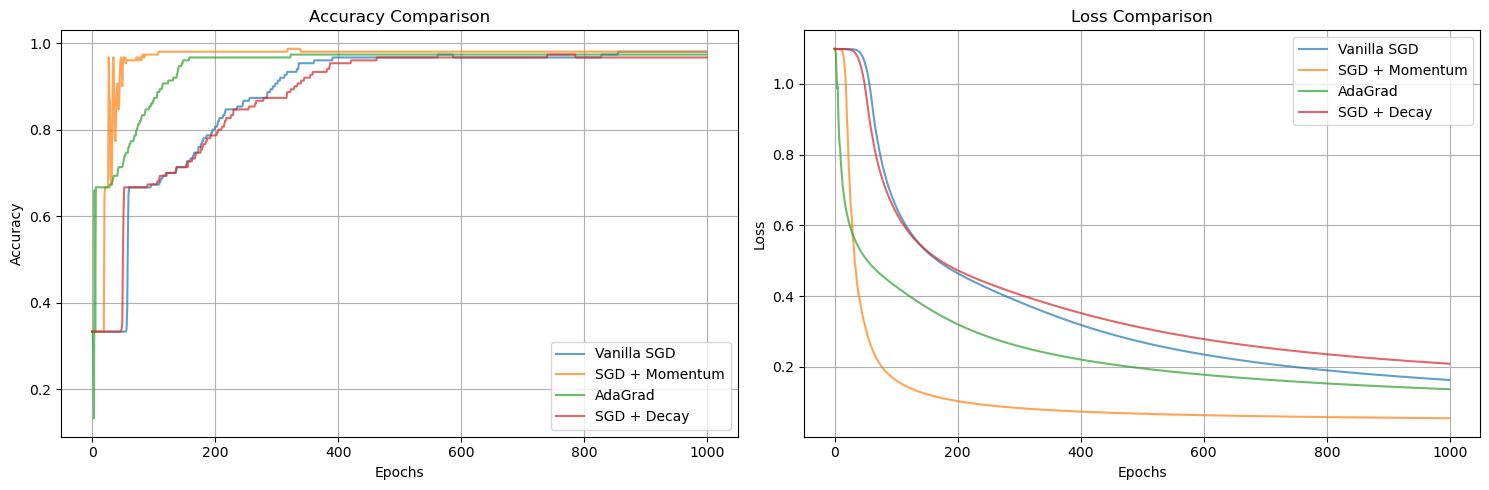

In [10]:
# Comparison Analysis
import matplotlib.pyplot as plt

print("\n=== COMPARISON RESULTS ===")
print(f"Final Accuracy - Vanilla SGD: {acc_vanilla[-1]:.3f}")
print(f"Final Accuracy - SGD with Momentum: {acc_momentum[-1]:.3f}")
print(f"Final Accuracy - AdaGrad: {acc_adagrad[-1]:.3f}")
print(f"Final Accuracy - SGD with Decay: {acc_decay[-1]:.3f}")

# Find stabilization epochs (when loss change < 0.001 for 50 consecutive epochs)
def find_stabilization_epoch(losses, threshold=0.001, window=50):
    for i in range(window, len(losses)):
        recent_losses = losses[i-window:i]
        if max(recent_losses) - min(recent_losses) < threshold:
            return i - window
    return len(losses)

stab_vanilla = find_stabilization_epoch(loss_vanilla)
stab_momentum = find_stabilization_epoch(loss_momentum)
stab_adagrad = find_stabilization_epoch(loss_adagrad)
stab_decay = find_stabilization_epoch(loss_decay)

print(f"\nStabilization Epochs:")
print(f"Vanilla SGD: {stab_vanilla}")
print(f"SGD with Momentum: {stab_momentum}")
print(f"AdaGrad: {stab_adagrad}")
print(f"SGD with Decay: {stab_decay}")

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(acc_vanilla, label='Vanilla SGD', alpha=0.7)
plt.plot(acc_momentum, label='SGD + Momentum', alpha=0.7)
plt.plot(acc_adagrad, label='AdaGrad', alpha=0.7)
plt.plot(acc_decay, label='SGD + Decay', alpha=0.7)
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss_vanilla, label='Vanilla SGD', alpha=0.7)
plt.plot(loss_momentum, label='SGD + Momentum', alpha=0.7)
plt.plot(loss_adagrad, label='AdaGrad', alpha=0.7)
plt.plot(loss_decay, label='SGD + Decay', alpha=0.7)
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()